# TP n°2 - Linear Image Denoising

Adapted from Gabriel Peyré's http://www.numerical-tours.com/

This notebook aims to familiarize you with the Fourier transform and with image manipulation.

In [20]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import astronaut
from skimage.transform import resize
from skimage.color import rgb2gray

# seeding the code makes the results reproducible
# change the seed to get new realizations of numpy random variables
np.random.seed(33)  

## Loading an image

Let us start by loading a picture and displaying it.

In [21]:
# Loading the image.
x0 = astronaut()

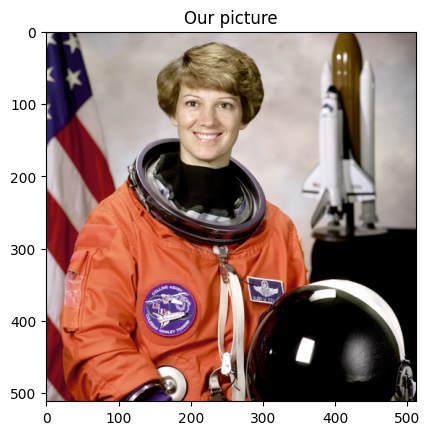

In [22]:
# To plot an image, we use `plt.imshow`.
plt.imshow(x0)
plt.title("Our picture")
plt.show()

**Question 1:** What is the type of x0? And its shape?

In [23]:
# Enter your code here

type = <class 'numpy.ndarray'>
shape = (512, 512, 3)


Let us resize this image to $n\times n$, and turn it into a grayscale image.

In [24]:
n = 256
N = n ** 2

# Resizing the image.
x0 = resize(x0, (n, n))

# Converting the image to grayscale.
x0 = rgb2gray(x0)

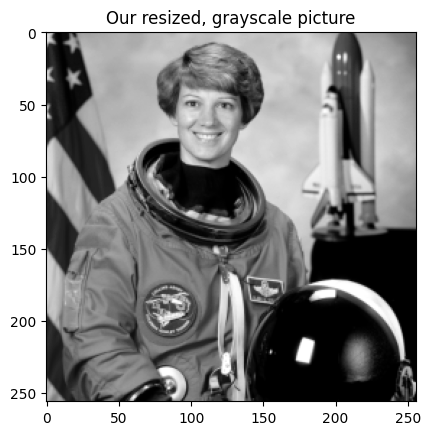

In [25]:
# Tip: to plot a grayscale image in gray instead of the default green, use `cmap="gray"`.
plt.imshow(x0, cmap="gray")
plt.title("Our resized, grayscale picture")
plt.show()

## Adding noise to the image

We will simulate noisy acquisition by adding some
white noise (each pixel is corrupted by adding an independent Gaussian
variable).

This is useful to test empirically the performance of our methods.

We add some noise to the image to obtain the noisy signal $y = x_0 + w$.
Here $w$ is a realization of a Gaussian white noise of variance
$\sigma^2$.

In [26]:
# Define the variance of the noise.
sigma = .08

# Define the noisy image.
y = x0 + sigma * np.random.standard_normal(x0.shape)

**Question 2:** Plot the noisy image.

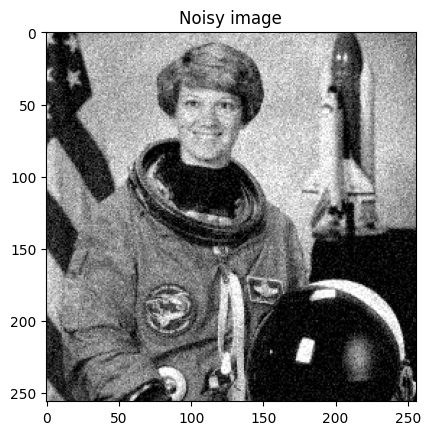

In [27]:
# Tip: Because of the noise, some values may not be in [0, 1] anymore.
# To clip (=limit) the values of an array, use `np.clip` -> see numpy documentation.

...

## Method 1 : Linear Image Denoising

Consider an estimator $x \in \mathbb R^N$ of $x_0$ that only
depends on the observation $y$.

If $x$ is obtained by translation invariant linear denoising, it is necessarily a convolution
with a kernel $h$
$$ x = y \star h $$
where the periodic convolution between two 2D arrays is defined as
$$ (a \star b)_i = \sum_j a(j) b(i-j). $$

It can be computed over the Fourier domain as
$$ \forall \omega, \quad \hat x(\omega) = \hat x_0(\omega) \odot \hat h(\omega). $$

Therefore, to define $x$, we just need to choose our kernel $h$.

**Question 3:** Implement the convolution function $(a, b) \mapsto a\star b$.

In [28]:
# `np.fft.fft2` is the 2D Fourier transform.
# `np.fft.ifft2` is the inverse 2D Fourier transform.
# `np.real` is the real part of a complex number.
# Here, we need to convert to a real number to get rid of the imaginary part (which should be 0).

cconv = lambda a,b : ...

Let us define a Gaussian kernel parametrized by its bandwidth mu.

In [29]:
normalize = lambda h: h / np.sum(h.flatten()) # L1 normalization.

# Create a grid centered around 0.
t = np.concatenate((np.arange(0, n // 2), np.arange(-n // 2, 0))).T
yy, xx = np.meshgrid(t, t)

# Define the Gaussian kernel.
h = lambda mu: normalize(np.exp(-(xx ** 2 + yy ** 2) / (2 * mu ** 2)))

**Question 4:** Display the filter $h$ and its Fourier transform. Note that $\hat{h}$ is a real-valued function.

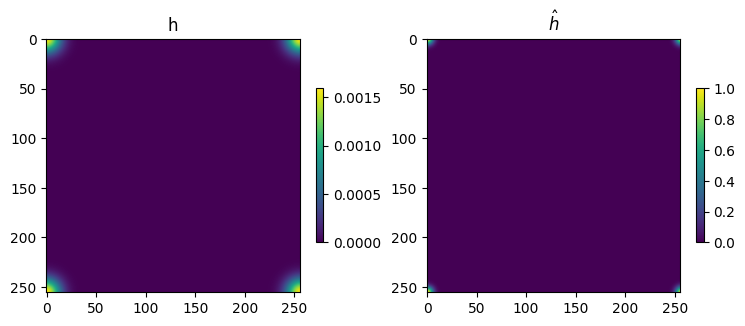

In [43]:
mu = 10
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].set_title('h')
h_fig = axes[0].imshow(...)
fig.colorbar(h_fig, ax=axes[0], shrink=0.5)

axes[1].set_title('$\hat h$')
h_hat_fig = axes[1].imshow(...)
fig.colorbar(h_hat_fig, ax=axes[1], shrink=0.5)

plt.show()

Notice that because the filter is centered around 0, it's localized in the egdes of the images.

To improve readability, we can use `np.fft.fftshift`.

**Question 5:** Use `np.fft.fftshift` to display the centered filter and it's Fourier transform.

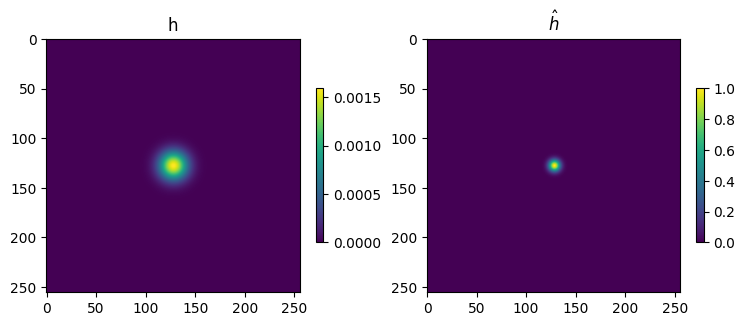

In [45]:
mu = 10
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].set_title('h')
h_fig = axes[0].imshow(...)
fig.colorbar(h_fig, ax=axes[0], shrink=0.5)

axes[1].set_title('$\hat h$')
h_hat_fig = axes[1].imshow(...)
fig.colorbar(h_hat_fig, ax=axes[1], shrink=0.5)

plt.show()

**Question 6:** Define the denoising function $x \mapsto h_\mu \star x$ and display the denoised signal for several values of $\mu$.

In [46]:
def denoise(x, mu):
    ...

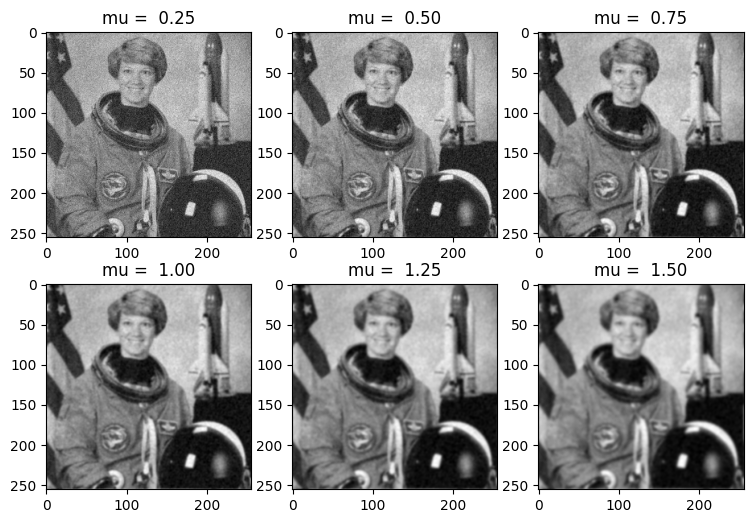

In [55]:
mus = np.linspace(0.25, 1.5, 6)
f, axes = plt.subplots(2, 3, figsize=(9, 6))
for i, mu in enumerate(mus):
    ... # do not forget to display the values of mu!
plt.show()

**Question 7:** Display the evolution of the oracle denoising error
$ ||y-x_0|| $ as a function of $\mu$.

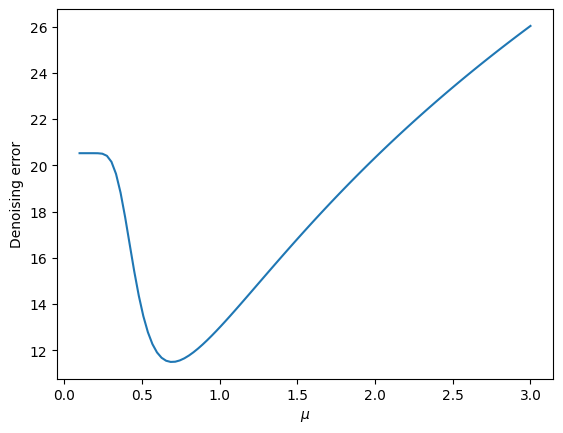

In [66]:
mus = np.linspace(0.1, 3., 100)
norms = ...
plt.plot(mus, norms)
plt.xlabel(r"$\mu$")
plt.ylabel("Denoising error")
plt.show()

**Question 8:** Set $\mu$ to the value of the optimal parameter and display the result.

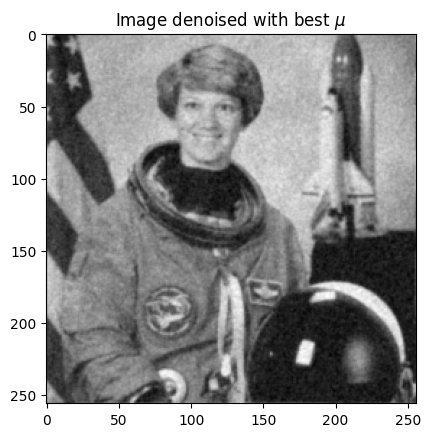

In [73]:
best_mu = ...

## Method 2: Wiener Filtering

Let $y = x_0 + w$ a noisy observation as above, with $w$ a realization of $W \sim\mathcal N(0,\sigma^2 \text{Id})$ and $x_0$ a realization of $X_0\sim \mathcal{N}(0, C)$ where the covariance $C$ is **stationary** and can therefore be summarized by a vector $c$ of size $n^2$.
Denote $P_{X_0}(\omega) \coloneqq \hat c(\omega)$ the power-spectrum of $x_0$.

The (oracle) optimal filter $h^*$ minimizes the risk
$$ R(h) = \mathbb E_{W,X_0}( || X_0 - h \star (X_0 + W) ||^2 ). $$

One can show that the solution of this problem, the so-called Wiener filter,
is defined as
$$ \forall \omega, \quad \hat h(\omega) = \frac{ P_{X_0}(\omega) }{ P_{X_0}(\omega) + \sigma^2 }. $$


We estimate $ P_{X_0} $ using the periodogram associated to the
realization $x_0$, i.e.
$$ P_{X_0} \approx \frac{1}{N}|\hat x_0|^2, $$
where the absolute value is taken **coordinatewise**.

In [16]:
P = 1 / N * (abs(np.fft.fft2(x0)) ** 2)

**Question 6:** Compute the approximate Wiener filter $\hat h(\omega)$. Note that this is a theoretical filter, because in practice one does not have access to $x_0$. Display it.

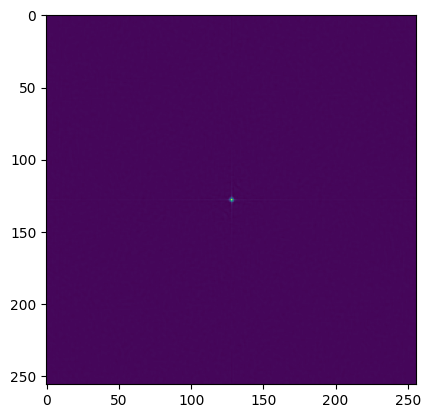

In [17]:
h_wiener = ...

# This might be a very small dot.
plt.imshow(...)
plt.show()

**Question 7:** Display the denoising result.

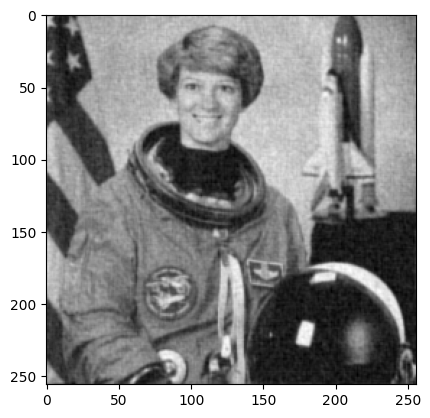

In [18]:
plt.imshow(...)
plt.show()

Note that the hypothesis of stationarity of $X_0$ is not very realistic for such piecewise-regular
signal.